# Reward Modeling
Evaluate and select the best large language model that can understand and follow complex instructions and generate high-quality responses. The model should be fine-tuned to align with specific goals and criteria.

By training a Reward Model, we can guide the LLM to prioritize certain behaviors, ensuring it generates responses that not only meet technical standards but also align with the our values and objectives.

Let's dive into the process of creating and training a Reward Model by using the **Transformer Reinforcement Learner** (TRL) library from Hugging Face.


# Setup
## Installing required libraries


In [1]:
# First, check CUDA version in Colab
!nvcc --version

# Uninstall any existing PyTorch to avoid conflicts
!pip uninstall torch torchvision torchaudio -y

# Install PyTorch with CUDA 12.1 (most compatible with Colab)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other dependencies with compatible versions
!pip install fsspec==2024.9.0  # Compatible with datasets
!pip install datasets==3.2.0
!pip install trl==0.11
!pip install huggingface_hub==0.30.0
!pip install transformers==4.43.4
!pip install peft==0.14.0
!pip install nltk==3.9.1 rouge_score==0.1.2
!pip install bitsandbytes==0.43.1
!pip install matplotlib==3.10.0

# After installation, restart runtime
print("Please restart the runtime: Runtime -> Restart Session")

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 843.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.5 MB/s eta 0:00:00
     

After running the above code, restart the kernel before running the following cell.


## Importing required libraries


In [1]:
import json
from datasets import load_dataset, DatasetDict
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, TrainingArguments
from peft import LoraConfig, TaskType
from transformers import TrainingArguments
from trl import RewardTrainer, RewardConfig
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
# Disable warnings for a cleaner notebook or console experience
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Defining helper functions


In [2]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data


## Data set

We will use the Dahoas/synthetic-instruct-gptj-pairwise data set from Hugging Face, a synthetic data set that is designed for training and evaluating instruction-following models. This data set includes pairs of prompts and responses, where one response is preferred over the other. The primary use case is to train models to distinguish between better and worse responses, essential for tasks like reinforcement learning with human feedback (RLHF).

### Applications
- **Reinforcement learning**: Enhancing models to prefer better responses based on feedback
- **Fine-tuning language models**: Improving the performance of models on instruction-following tasks
- **Evaluation**: Assessing the ability of models to distinguish between high- and low-quality responses


In [3]:
# Load the Dahoas/synthetic-instruct-gptj-pairwise dataset
dataset = load_dataset("Dahoas/synthetic-instruct-gptj-pairwise")
# Display the dataset
print(dataset)

dataset_infos.json: 0.00B [00:00, ?B/s]

(…)-00000-of-00001-1e5d57b93c448e7a.parquet:   0%|          | 0.00/18.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33143 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 33143
    })
})


### Features

Let's inspect a few samples.

```Prompt:``` A text prompt that the model should respond to

```Chosen:``` The preferred response to the prompt

```Rejected:``` The less preferred response to the prompt


In [5]:
for i in range(10):
    print('prompt')
    print(dataset["train"][i]['prompt'],'\n')

    print('chosen')
    print(dataset[ 'train'][i]['chosen'],'\n')

    print('rejected')
    print(dataset[ 'train'][i]['rejected'],'\n')
    print('---------------------------\n')

prompt
I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs. 

chosen
Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients. 

rejected
How do I store a

## Model and Tokenizer Setup
We can use the GPT-2 model for sequence classification, which helps in determining the quality of responses.

To initialize the tokenizer and model, we use `GPT2Tokenizer.from_pretrained` and `GPT2ForSequenceClassification.from_pretrained`, respectively, with `num_labels` set to 1 for ranking (a numerical score value). To handle padding, set the `pad_token` of the tokenizer to be the same as the `eos_token` (end-of-sequence token). Similarly, configure the model to use the `eos_token_id` as the `pad_token_id`. This setup ensures that the tokenizer and model are correctly initialized and prepared for sequence classification tasks with GPT-2.


In [6]:
# Define the model name or path
model_name_or_path = "gpt2"

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = GPT2ForSequenceClassification.from_pretrained(model_name_or_path, num_labels=1)

# Add special tokens if necessary
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Define the maximum length
max_length = 1024

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, preprocess the data set for training. Then combine the prompt with the chosen and rejected responses into a format suitable for input into the model. This process helps create clear input-output pairs for the model to learn from.

`Lambda Function`: Define a lambda function `get_res` that takes the data set and a response type (chosen or rejected) and combines the prompt with the respective response. Each entry is formatted as a dialogue between "Human" and "Assistant".


In [7]:
get_res=lambda dataset,res:[  "\n\nHuman: "+prompt + "\n\nAssistant: "+resp for prompt, resp in zip(dataset["train"]["prompt"], dataset["train"][res])]

`Chosen Samples`: Apply the `get_res` function to create a list of chosen samples.

`Rejected Samples`: Similarly, create a list of rejected samples using the same function.

After applying the function,  you get the following results.


In [8]:
chosen_samples=get_res( dataset,'chosen')
rejected_samples=get_res( dataset,'rejected')
print('chosen',chosen_samples[0])
print('rejected',rejected_samples[0])

chosen 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
rejected 

Huma

To facilitate the training process, create new columns in the data set that combine the prompt with chosen and rejected responses. This combination helps in evaluating the responses in a structured dialogue format.

**Function definition**: Define a function `add_combined_columns` that takes an example (a single data point) and adds two new columns:
- `prompt_chosen`: Combines the `prompt` with the `chosen` response in the same labeled format.
- `prompt_rejected`: Combines the `prompt` with the `rejected` response in the same labeled format.

**Apply function**: The `map` method is used to apply this function to each example in the training split of the data set. This method iterates over all the examples and modifies them in place.


In [9]:
# Define a function to combine 'prompt' with 'chosen' and 'rejected' responses
def add_combined_columns(example):
    # Combine 'prompt' with 'chosen' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_chosen'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["chosen"]

    # Combine 'prompt' with 'rejected' response, formatting it with "Human:" and "Assistant:" labels
    example['prompt_rejected'] = "\n\nHuman: " + example["prompt"] + "\n\nAssistant: " + example["rejected"]

    # Return the modified example
    return example

# Apply the function to each example in the 'train' split of the dataset
dataset['train'] = dataset['train'].map(add_combined_columns)

Map:   0%|          | 0/33143 [00:00<?, ? examples/s]

When using pretrained transformers for classification tasks, understanding the maximum sequence length supported by the model is crucial, as pretrained transformers have a fixed maximum token length, for example, GPT-2 has 1024 tokens. Inputs longer than this are truncated, potentially losing important information. So a function is written to determine the max length.


In [10]:
get_max_len= lambda samples: max([len(sample) for sample in samples])
get_max_len

<function __main__.<lambda>(samples)>

In [11]:
print("rejected samples length",get_max_len(rejected_samples))
print("chosen samples length",get_max_len(chosen_samples))

rejected samples length 5011
chosen samples length 3167


Sometimes, you might want to identify samples shorter than a specified maximum length. This can be useful for filtering or handling special cases during preprocessing.

The lambda function `find_short` takes a data set and a maximum length (`max_length`) as input. It uses a list comprehension to iterate over each example in the data set, enumerating both the index and the (chosen, rejected) pair. It zips `prompt_chosen` and `prompt_rejected` to pair each chosen response with its corresponding rejected response. For each pair, it checks if the length of either `chosen` or `rejected` is less than the specified `max_length`. If the condition is met, the index of that pair is included in the resulting list. The resulting list contains the index of all examples where either `prompt_chosen` or `prompt_rejected` is shorter than the specified `max_length`.


In [12]:
find_short = lambda dataset, max_length: [
    i for i, (chosen, rejected) in enumerate(zip(dataset['prompt_chosen'], dataset['prompt_rejected']))
    if len(chosen) < max_length or len(rejected) < max_length
]

To ensure that your data set only includes samples that meet the required length criteria, filter out any samples that are shorter than the specified `max_length`. This step is important for maintaining consistency in the input data for the model.

Now, use the GPT-2 model for classification with a max length of 1024. First, set the maximum length (`max_length`) to 1024. The `find_short` function is then called with the training data set (`dataset['train']`) and this maximum length as arguments to find indices of examples where either `prompt_chosen` or `prompt_rejected` is shorter than the specified `max_length`. The resulting index (`subset_indices`) is used to create a subset of the training data set by selecting only the examples at these indices. The training data set (`dataset['train']`) is updated to this subset, and the `subset_indices` are returned or printed.


In [13]:
max_length=1024
subset_indices=find_short (dataset['train'], max_length)
dataset['train'] = dataset['train'].select(subset_indices)
subset_indices[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


 The ```preprocess_function``` tokenizes the ```prompt_chosen``` and ```prompt_rejected``` keys, which are crucial for the RewardTrainer. The ```chosen``` key represents the preferred responses, while the ```rejected``` key represents the less preferred responses.
 Tokenizing these keys allows the model to process and understand the differences between high-quality and low-quality responses. By providing both ```chosen``` and ```rejected``` inputs, the RewardTrainer can learn to distinguish and prioritize better responses, which is essential for training models to follow instructions effectively.


In [14]:
# Define a preprocessing function to tokenize the 'prompt_chosen' and 'prompt_rejected' keys
def preprocess_function(examples):
    # Tokenize the 'prompt_chosen' text with truncation and padding to the maximum length
    tokenized_chosen = tokenizer(examples['prompt_chosen'], truncation=True, max_length=max_length, padding="max_length")

    # Tokenize the 'prompt_rejected' text with truncation and padding to the maximum length
    tokenized_rejected = tokenizer(examples['prompt_rejected'], truncation=True, max_length=max_length, padding="max_length")

    # Return the tokenized inputs as a dictionary
    return {
        "input_ids_chosen": tokenized_chosen["input_ids"],  # Token IDs for 'chosen' responses
        "attention_mask_chosen": tokenized_chosen["attention_mask"],  # Attention masks for 'chosen' responses
        "input_ids_rejected": tokenized_rejected["input_ids"],  # Token IDs for 'rejected' responses
        "attention_mask_rejected": tokenized_rejected["attention_mask"],  # Attention masks for 'rejected' responses
    }


The `input_ids_chosen` and `input_ids_rejected` fields contain the token IDs for the `chosen` and `rejected` responses, respectively, which are the numerical representations of the text used by the model. The `attention_mask_chosen` and `attention_mask_rejected` fields contain the attention masks for the `chosen` and `rejected` responses, respectively, which indicates tokens that should be attended to (1) and should ignore (0). These fields are crucial for the `RewardTrainer` because they provide the necessary tokenized inputs and attention masks for both the preferred and less preferred responses. By comparing the token IDs and attention patterns of the `chosen` and `rejected` responses, the `RewardTrainer` can distinguish between high- and low-quality responses, thereby improving the model's ability to prioritize better responses in instruction-following tasks.

You can apply the ```reprocess_function``` to one sample:


In [15]:
example=preprocess_function(dataset['train'][0])
example.keys()

dict_keys(['input_ids_chosen', 'attention_mask_chosen', 'input_ids_rejected', 'attention_mask_rejected'])

Now, create a dictionary with 'chosen' and 'rejected' samples from the training data set. This dictionary is created to make it easier to validate the model later.


In [16]:
train_str={'chosen': [sample for sample in dataset['train'] ['prompt_chosen']], 'rejected':[sample for sample in dataset['train'] ['prompt_rejected']]}

The code applies the preprocess_function to each example in the training data set using the map method, which tokenizes the ```prompt_chosen``` and ```prompt_rejected``` texts. The `batched = True` parameter allows the function to process multiple examples at once, improving efficiency. Additionally, the `remove_columns` parameter specifies a list of columns (```prompt```, ```chosen```, ```rejected```, ```prompt_chosen```, ```prompt_rejected```) to be removed from the data set after processing. This ensures that only the tokenized inputs and attention masks generated by `preprocess_function` are retained, simplifying the data set structure and making it more suitable for model training and validation.


In [17]:
dataset['train'] = dataset['train'].map(preprocess_function, batched=True, remove_columns=['prompt',"chosen", "rejected",'prompt_chosen', 'prompt_rejected'])

Map:   0%|          | 0/33043 [00:00<?, ? examples/s]

The only columns left are the tokens and masks indexes.


In [18]:
dataset.column_names

{'train': ['input_ids_chosen',
  'attention_mask_chosen',
  'input_ids_rejected',
  'attention_mask_rejected']}

Finally, split the data set into training and testing data sets.


In [19]:
split_dataset = dataset['train'].train_test_split(test_size=0.2)

# Create a DatasetDict to hold train and test splits
dataset_dict = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test'],
})


## LoRA configuration
Now that the training data set is ready, we can use the pretrain transformer model to start training. However, it is advisable to use a more efficient LoRA configuration for the model. Now, define the LoRA configuration and training arguments.

First, initialize a `LoraConfig` configuration for low-rank adaptation (LoRA) in a sequence classification task. The configuration is created by using the `LoraConfig` class from the `peft` library and specifies several parameters:

- **task_type=TaskType.SEQ_CLS**: Specifies the type of task, that is, the sequence classification for this lab.
- **inference_mode=False**: Indicates that the configuration is for training mode rather than inference.
- **r=8**: Sets the rank of the LoRA matrices.
- **lora_alpha=32**: Sets the alpha value for scaling the LoRA matrices.
- **lora_dropout=0.1**: Specifies the dropout rate for the LoRA layers, helping to prevent overfitting.
- **target_modules=["attn.c_attn", "attn.c_proj"]**: Lists the specific attention layers in the model that will be adapted using LoRA. This includes the "attn.c_attn" and "attn.c_proj" modules.

This configuration is useful for applying LoRA to the specific parts of the model, enabling efficient fine-tuning by adapting only a subset of the model parameters.


In [20]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["attn.c_attn", "attn.c_proj"]  # Target attention layers
)

## Training arguments

Define the training arguments by using the `TrainingArguments` class from the `transformers` library. These arguments configure various aspects of the training process:

- **per_device_train_batch_size=3**: Sets the batch size per device (GPU/CPU) to 3
- **num_train_epochs=3**: Specifies the number of training epochs and is set to 3.
- **gradient_accumulation_steps=8**: Accumulates gradients over 8 steps before performing a backward/update pass, effectively increasing the batch size
- **learning_rate=1.41e-5**: Sets the learning rate for the optimizer to 1.41e-5
- **output_dir="./model_output3"**: Specifies the directory where the model checkpoints and other outputs are saved
- **logging_steps=10**: Logs training progress every 10 steps
- **evaluation_strategy="steps"**: Sets the evaluation strategy to evaluate the model at regular steps
- **eval_steps=500**: Evaluates the model every 500 steps
- **save_steps=500**: Saves the model checkpoint every 500 steps
- **save_total_limit=2**: Limits the number of saved checkpoints to 2, deleting older checkpoints to save space

These arguments configure the training loop, including batch size, learning rate, logging, evaluation, and checkpoint-saving strategies.


In [21]:
# Define training arguments

training_args = RewardConfig(
    per_device_train_batch_size=3,  # Set to 3
    num_train_epochs=3,  # Set to 3
    gradient_accumulation_steps=8,
    learning_rate=1.41e-5,
    output_dir="./model_output3",
    logging_steps=10,
    evaluation_strategy="steps",  # Note: use full parameter name
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    center_rewards_coefficient=0.01,  # This was causing the AttributeError
    max_length=512,  # Maximum sequence length for rewards
)

### RewardTrainer

The `RewardTrainer` is a specialized trainer that is designed to train models with a reward signal. This is often used in reinforcement learning scenarios where the model learns to optimize for better responses. It is initialized with several parameters:

- **model**: The model to be trained
- **args**: The training arguments. Typically, an instance of `TrainingArguments`
- **tokenizer**: The tokenizer used to process the text inputs
- **train_dataset**: The training data set
- **eval_dataset**: The evaluation data set
- **peft_config**: The configuration for LoRA

The `RewardTrainer` orchestrates the training process, handling tasks such as batching, optimization, evaluation, and saving model checkpoints. It is particularly useful for training models that need to learn from feedback signals, improving their ability to generate high-quality responses.


In [22]:
# Initialize RewardTrainer
trainer = RewardTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=dataset_dict['train'],
    eval_dataset=dataset_dict['test'],
    peft_config=peft_config,
)

The next step is training, saving, and evaluating a model by using the `RewardTrainer`. The `trainer.train()` method initiates the training process, where the model learns from the training data set, optimizing its parameters to improve performance. After training, the `trainer.save_model(output_dir)` method saves the trained model to the specified output directory, allowing for future use or deployment. Finally, the `trainer.evaluate()` method evaluates the model's performance on the evaluation data set, returning metrics that provide insights into how well the model performs. These metrics are then printed to give a detailed view of the model's evaluation results.

Note: The training takes a very long time. Therefore, the model has already been trained and saved for you. If you want to train the model yourself, go ahead and uncomment the following cell.


In [ ]:
output_dir="./model_output3"
# Train the model
trainer.train()
# Save the model
trainer.save_model(output_dir)
# Evaluate the model
metrics = trainer.evaluate()
print(metrics)
model.config.save_pretrained("./backup")

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Accuracy
500,0.199300,0.159330,0.961870


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.9924, 0.0076] │
│                                               │                                              │                  │
│ Human: What is the most spoken language in    │ Human: What is the most spoken language in   │                  │
│ the world.                                    │ the world.                                   │                  │
│                                               │                                              │                  │
│ Assistant: The most spoken language in the    │ Assistant: Well, languages were started out  │                  │
│ world is Mandarin Chinese, with over 1.1      │ in order, but today there are dozens of      │                  │
│ billion speakers worldwide.                   │ languages in addition to English, a very     │                  │
│                                               │ important language.                          │                  │
│                                               │         I’m speaking languages because I     │                  │
│                                               │ want to learn your dialects, which will give │                  │
│                                               │ your ability to communicate.                 │                  │
│                                               │         For example, some languages are      │                  │
│                                               │ closely related to English, and one is very  │                  │
│                                               │ close to another language, so when people    │                  │
│                                               │ speak that language, they also can speak     │                  │
│                                               │ with their hand or mouth.                    │                  │
│                                               │         At the moment that’s English, people │                  │
│                                               │ speak English, the closest language of which │                  │
│                                               │ people know, as English.                     │                  │
│                                               │         This is a great place to start,      │                  │
│                                               │ because we can easily find the rest of the   │                  │
│                                               │ languages on our website.  You’ll need to be │                  │
│                                               │ patient with some of our less-languages, and │                  │
│                                               │ English is a great example, but English is a │                  │
│                                               │ great language!                              │                  │
│                                               │         How would you get to this number.    │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│                                               │                                              │ [0.9998, 0.0002] │
│                                               │                                              │                  │
│ Human: What are the latest trends in          │ Human: What are the latest trends in         │                  │
│ technology.                                   │ techno

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ chosen_text                                   ┃ rejected_text                                ┃ logits           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│                                               │                                              │ [0.998, 0.002]   │
│                                               │                                              │                  │
│ Human: What is the most spoken language in    │ Human: What is the most spoken language in   │                  │
│ the world.                                    │ the world.                                   │                  │
│                                               │                                              │                  │
│ Assistant: The most spoken language in the    │ Assistant: Well, languages were started out  │                  │
│ world is Mandarin Chinese, with over 1.1      │ in order, but today there are dozens of      │                  │
│ billion speakers worldwide.                   │ languages in addition to English, a very     │                  │
│                                               │ important language.                          │                  │
│                                               │         I’m speaking languages because I     │                  │
│                                               │ want to learn your dialects, which will give │                  │
│                                               │ your ability to communicate.                 │                  │
│                                               │         For example, some languages are      │                  │
│                                               │ closely related to English, and one is very  │                  │
│                                               │ close to another language, so when people    │                  │
│                                               │ speak that language, they also can speak     │                  │
│                                               │ with their hand or mouth.                    │                  │
│                                               │         At the moment that’s English, people │                  │
│                                               │ speak English, the closest language of which │                  │
│                                               │ people know, as English.                     │                  │
│                                               │         This is a great place to start,      │                  │
│                                               │ because we can easily find the rest of the   │                  │
│                                               │ languages on our website.  You’ll need to be │                  │
│                                               │ patient with some of our less-languages, and │                  │
│                                               │ English is a great example, but English is a │                  │
│                                               │ great language!                              │                  │
│                                               │         How would you get to this number.    │                  │
├───────────────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────┤
│                                               │                                              │ [0.9118, 0.0882] │
│                                               │                                              │                  │
│ Human: What are the latest trends in          │ Human: What are the latest trends in         │                  │
│ technology.                                   │ techno

It is taking too long, so download a pretained model.

If you have managed to train the model, you can skip this step.


In [23]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip

--2025-07-26 15:39:20--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VZcK8FJ-kQ3nEJoxWGNYTQ/RetriverTrainerModel.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13238247 (13M) [application/zip]
Saving to: ‘RetriverTrainerModel.zip’

RetriverTrainerMode 100%[===================>]  12.62M  5.39MB/s    in 2.3s    

2025-07-26 15:39:24 (5.39 MB/s) - ‘RetriverTrainerModel.zip’ saved [13238247/13238247]



In [24]:
!unzip -o RetriverTrainerModel.zip -d extracted_model

Archive:  RetriverTrainerModel.zip
   creating: extracted_model/model_output3/
  inflating: extracted_model/__MACOSX/._model_output3  
   creating: extracted_model/model_output3/checkpoint-2500/
  inflating: extracted_model/__MACOSX/model_output3/._checkpoint-2500  
  inflating: extracted_model/model_output3/adapter_model.safetensors  
  inflating: extracted_model/__MACOSX/model_output3/._adapter_model.safetensors  
  inflating: extracted_model/model_output3/.DS_Store  
  inflating: extracted_model/__MACOSX/model_output3/._.DS_Store  
  inflating: extracted_model/model_output3/tokenizer_config.json  
  inflating: extracted_model/__MACOSX/model_output3/._tokenizer_config.json  
  inflating: extracted_model/model_output3/special_tokens_map.json  
  inflating: extracted_model/__MACOSX/model_output3/._special_tokens_map.json  
  inflating: extracted_model/model_output3/config.json  
  inflating: extracted_model/__MACOSX/model_output3/._config.json  
  inflating: extracted_model/model_outpu


## Evaluating the model
The `RewardTrainer` uses pairwise comparison to measure the model's ability to distinguish between high and low-quality responses. In pairwise comparison, the model is presented with two responses: one chosen as the preferred response and one as the less preferred (rejected) response. The model evaluates each response in the pair and assigns a score or reward based on its learned criteria. To perform an evaluation, two separate responses are inputted, and the model generates a score that is logit for each response. The response with the higher score is selected as the preferred one, demonstrating the model's capability to accurately prioritize better responses.

First, load the model.


In [25]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT2ForSequenceClassification.from_pretrained("./extracted_model/model_output3", num_labels=1).to(DEVICE)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropou

>Note: You can safely ignore the above warning.


Next, plot the loss. You can see it converges nicely.

Run the below code to unzip the file.


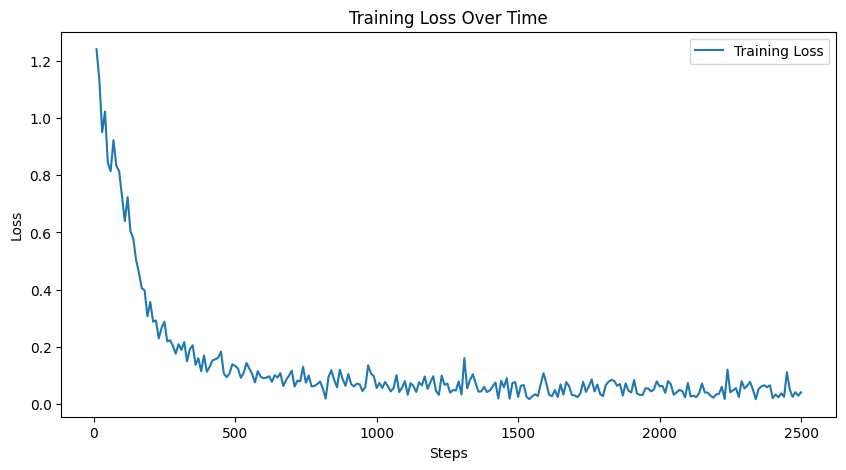

In [26]:
log_file = f"extracted_model/model_output3/checkpoint-2500/trainer_state.json"

# Read the log file
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract training loss values
steps = []
losses = []
for log in logs["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

The code first tokenizes `text1` by using the tokenizer, converting it into the format required by the model. The `tokenizer` function processes the input text into tensors with padding and truncation to ensure uniform input length, up to a maximum of 512 tokens. The `inputs` are then moved to the GPU, if available, for faster computation. The `model` is also transferred to the GPU. The inputs dictionary is updated to move all of its items to the device (GPU or CPU).

The model is then used to generate outputs without computing gradients (`torch.no_grad()`), making the inference process faster and more memory-efficient. The score, the logits from the model's output, are extracted, representing the raw predictions. These logits are then passed through a sigmoid function to convert them into probabilities, which can be interpreted as the model's confidence in the projections. The resulting probabilities are printed or returned for further use.


In [27]:
text1=train_str['chosen'][0]
print(text1)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.


In [28]:
inputs = tokenizer(text1, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_1 = outputs.logits
print("Score :",logit_1 )

Score : tensor([[7.7441]], device='cuda:0')


Do the same for the rejected sample


In [29]:
text2=train_str['rejected'][0]
print(text2)



Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: How do I store a bagels for eating at a later date?


 You can place the bagels in an airtight container and reheat them in the microwave.  Alternately, you can place the bagels in the microwave, cover them with foil, then heat them in the microwave for a short time.


In [30]:
inputs = tokenizer(text2, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move inputs to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
logit_2 = outputs.logits
print("Score :",logit_2 )

Score : tensor([[-7.7179]], device='cuda:0')


To demonstrate how pairwise comparison is useful for evaluating and ranking responses based on the model's predictions, use the following code that performs a pairwise comparison. To determine which of the two responses, represented by `logit_1` and `logit_2`, is preferred, compare the logits, which are raw scores output by the model that indicate the quality of the responses. If `logit_1` is greater than `logit_2`, the first response (`text1`) is selected as the better response, and the second response (`text2`) is rejected, printing both the selected and rejected responses along with their respective scores. Conversely, if `logit_2` is greater or equal, the second response (`text2`) is selected, and the first response (`text1`) is rejected, again printing both responses and their scores.


In [31]:
if logit_1 > logit_2:
    print("--------selected---------")
    print(text1, logit_1.detach().item())
    print("--------rejected---------")
    print(text2, logit_2.detach().item())
else:
    print("selected ")
    print(text2, logit_2.detach().item())
    print("rejected")
    print(text2, logit_2.detach().item())

--------selected---------


Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrien

Now, convert the process of tokenizing, generating a score, and comparing the outputs into two separate functions. The first function handles tokenizing the text and generating the model's output scores, while the second function performs the pairwise comparison of these scores. Structuring the code this way ensures that the process is modular and easier to manage, facilitating a clear and efficient workflow for evaluating and selecting the better response based on the model's predictions.


In [32]:
# Function to make a prediction and get the logits
def predict_and_get_logits(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform the forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the logits from the outputs
    logits = outputs.logits.squeeze().item()  # Assuming binary classification and batch size of 1

    return logits

In [33]:
# Function to compare two texts
def compare_texts(text1, text2):
    logit1 = predict_and_get_logits(text1)
    logit2 = predict_and_get_logits(text2)

    if logit1 > logit2:
        print("selected---------")
        print(text1, f"score: {logit1}")

        return text1
    else:
        print("selected---------")
        print(text2,  f"score: {logit2}")

        return text2

Finally,  evaluate the performance of a model by using a pairwise comparison approach over a subset of the data set. It begins by defining N, the number of samples to evaluate, and initializes a counter `correct_selections` to keep track of how many times the model correctly identifies the preferred response. The code then iterates over the first N pairs of chosen and rejected responses from the training data set (`train_str['chosen']` and `train_str['rejected']`).


In [34]:
# Define the number of samples to evaluate
N = 10

# Initialize a counter for correct selections
correct_selections = 0

# Iterate over the first N pairs of chosen and rejected responses
for chosen, rejected in zip(train_str['chosen'][0:N], train_str['rejected'][0:N]):
    # Print the chosen response for reference
    print("Chosen Response:\n", chosen)

    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / N

# Print the accuracy
print("Accuracy:", accuracy)

Chosen Response:
 

Human: I was wondering if you could walk me through the process of setting up a hydroponic garden for herbs.

Assistant: Sure! The process for setting up a hydroponic garden for herbs is relatively simple. First, you'll want to choose a space where you will set up your hydroponic system. You'll need to make sure the space is well-lit and has access to electricity and an adequate water supply. Next, you'll need to choose the type of hydroponic system you want to use. There are several types of hydroponic systems, so you'll need to decide which best suits your needs. Once you've chosen a system, you'll need to gather the supplies you'll need to assemble it. This includes things like pumps, growing trays, grow lights, and nutrients. Once you've assembled the system, you'll need to add your choice of herbs to the system. Lastly, you'll need to monitor and adjust the system as needed to ensure your herbs are getting the correct amount of light, water, and nutrients.
sele

## Exercise

#### Evaluate model's preference accuracy on a different subset of data

1. Define a new variable `K` to set the number of samples for evaluation from a different subset of the data.
2. Initialize a counter to track the number of correct selections made by the model.
3. Iterate over the `K` pairs of chosen and rejected responses from a different subset of the data set (for example, from the middle of the data set).
4. For each pair, use the `compare_texts` function to determine which response is better.
5. Count the number of times the model correctly identifies the chosen response.
6. Calculate and print the accuracy of the model's preferences on this different subset.


In [ ]:
# Write your code here

# Define the number of samples to evaluate from a different subset
K = 50

# Initialize a counter for correct selections
correct_selections = 0

# Determine the starting index for the different subset (e.g., middle of the dataset)
start_index = len(train_str['chosen']) // 2

# Iterate over K pairs of chosen and rejected responses from the different subset
for chosen, rejected in zip(train_str['chosen'][start_index:start_index + K], train_str['rejected'][start_index:start_index + K]):
    # Use the compare_texts function to determine which response is better
    selected_text = compare_texts(chosen, rejected)

    # Check if the selected text is the chosen response
    if selected_text == chosen:
        correct_selections += 1

# Calculate the accuracy as the ratio of correct selections to the total number of samples
accuracy = correct_selections / K

# Print the accuracy
print("Accuracy on different subset:", accuracy)

selected---------


Human: What's the best way to store old wines.

Assistant: The best way to store old wines is in a cool, dark place, away from direct sunlight and with temperatures that stay consistent. It is important to also ensure that the humidity levels are reasonably high, as this helps keep the cork moist. Finally, wine should always be stored on its side to keep the cork wet and prevent air from entering the bottle. score: 7.4293317794799805
selected---------


Human: What kids activities can I do that link to geography.

Assistant: One activity you can do with kids that link to geography is to make a map. Have them draw a map of their local area or even the world. They can use a variety of resources like books, online maps, and even globe ornaments. Talk about the features: rivers, mountains, cities, parks, and more. Give them a homework assignment to learn about some geographic area and then ask them to teach the class about that location. You can also bring in a variety 